# Compare Sentinel-2 and Mosaics


In [17]:
from datetime import timedelta
from glob import glob
import json
import os
import shutil
from dotenv import load_dotenv
import numpy as np
import pandas as pd
from pystac_client import Client
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import geopandas as gpd
import requests
import seaborn as sns
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
from odc.stac import configure_rio, stac_load
import xarray as xr
from PIL import Image


### Set up environment variables and the token

In [18]:
load_dotenv()  # take environment variables from .env.
os.environ['AWS_PROFILE'] = 'prodRead'

def get_new_token():
    auth_server_url = os.getenv("EDS_AUTH_URL")
    client_id = os.getenv("EDS_CLIENT_ID")
    client_secret = os.getenv("EDS_SECRET")
    token_req_payload = {'grant_type': 'client_credentials'}

    token_response = requests.post(
        auth_server_url,
        data=token_req_payload,
        verify=False,
        allow_redirects=False,
        auth=(client_id, client_secret)
    )
    token_response.raise_for_status()

    tokens = json.loads(token_response.text)
    return tokens['access_token']

token = get_new_token()

### Set up pystac client

In [31]:
api_url = os.getenv("EDS_API_URL")
print(api_url)
catalog = Client.open(api_url, headers={
    "Authorization": f"bearer {token}",
    "X-Signed-Asset-Urls": "true",
    "X-User-User-Type": "internal_user",
    "X-User-External-Downloads-Enabled": "true",
})

https://api.eds.earthdaily.com/archive/v1/stac/v1


### Helper functions

In [20]:
def get_bounds_polygon_dict() -> tuple:
    #gdf = gpd.GeoDataFrame.from_features([polygon_dict])
    gdf = gpd.read_file("brazil_aoi_test.geojson")
    polygon = gdf.geometry.iloc[0]
    bounds = polygon.bounds
    return bounds

def filter_duplicates(items, time_tolerance=timedelta(minutes=5)):
    # Filters items based on acquisition time with a given time tolerance. Useful for getting rid of duplicates
    # from overlapping Sentinel-2 tiles
    unique_items = []
    seen_times = []

    for item in items:
        acquisition_time = item.datetime
        is_duplicate = any([abs(acquisition_time - seen_time) < time_tolerance for seen_time in seen_times])

        if not is_duplicate:
            unique_items.append(item)
            seen_times.append(acquisition_time)

    return unique_items

def plot_images(site_name, filtered_dataset, offset=0):
    # Plot images for visualization. Useful for checking if the ROI is correct, whether there are clouds in the
    # imagery, etc.

    outputs_dir = f"outputs_{site_name}/"  # Location where the output files will be saved
    try:
        shutil.rmtree(outputs_dir)
    except FileNotFoundError:
        pass  # That's ok, nothing to cleaup
    os.makedirs(outputs_dir)

    # Loop through each time slice and generate RGB images
    for i in range(len(filtered_dataset.time)):
        ds = filtered_dataset.isel(time=i)
        # Stack the RGB bands into a numpy array
        rgb_numpy_array = np.stack([ds['red'].values, ds['green'].values, ds['blue'].values], axis=-1)

        # Get the date of the current time slice
        date = pd.to_datetime(ds.time.values).strftime("%Y-%m-%d-%s")

        # Apply offset to DN values
        rgb_numpy_array -= offset

        # Clip the values to avoid outliers
        rgb_numpy_array = np.clip(rgb_numpy_array, 0, 2000)

        # Normalize the pixel values between 0 and 1
        rgb_numpy_array = rgb_numpy_array / 2000.0

        # Convert the array to an image and save it
        Image.fromarray((rgb_numpy_array * 255).astype(np.uint8)).save(outputs_dir + f"{site_name}_{date}.png")

    # Get all the saved RGB images
    rgb_images = sorted(glob(outputs_dir + "*.png"))
    print(f"Number of images generated: {len(rgb_images)}")

    # Determine grid layout for displaying images
    n_cols, n_rows = 3, (len(rgb_images) + 2) // 3

    # Plot the RGB images with filenames as titles
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    for ax, png in zip(axes.flatten(), rgb_images):
        ax.imshow(mpimg.imread(png))
        ax.set_title(os.path.basename(png))
        ax.axis('off')

    # Hide any unused axes
    for ax in axes.flatten()[len(rgb_images):]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

bbox = get_bounds_polygon_dict()
print(bbox)

(-53.98643772948847, -29.557328688954595, -53.9826565563678, -29.550105447801776)


### Define the config

In [21]:
# define config
COLLECTION = "sentinel-2-l2a" 

# Set a start and end date
start_date = "2021-01-01"
end_date = "2021-12-31"
max_clouds = 50 # the maximum cloud cover percentage. Note this is over the WHOLE image, not just the ROI


### Generate and load the Sentinel-2 datacube

In [22]:
query = catalog.search(
    collections=[COLLECTION],
    datetime=f"{start_date}/{end_date}",
    bbox=bbox,
    query={"eo:cloud_cover":{"lt":max_clouds}} 
)

items = list(query.items())
required_assets = ["red", "green", "blue", "nir08"]
valid_items = []
for item in items:
    all_assets_valid = True
    for band in required_assets:
        asset = item.assets.get(band)
        if not asset:
            print(f"Asset for band '{band}' not found, skipping item.")
            all_assets_valid = False
            break

        asset.href = asset.extra_fields.get('alternate', {}).get('download', {}).get('href', asset.href)

        response = requests.get(asset.href, stream=True)
        if response.status_code != 200:
            all_assets_valid = False
            break

    if all_assets_valid:
        valid_items.append(item)

print(f"Found: {len(valid_items):d} total datasets")

filtered_items = filter_duplicates(valid_items)

print(f"Found: {len(filtered_items):d} unique datasets")

final_dataset = stac_load(
    filtered_items,
    bands=("red", "green", "blue","nir08"),
    crs="epsg:3857", # since resolution is in metres, we need to use a projected CRS
    resolution=5, # the resolution of the output image in metres
    chunks={'x': 2048, 'y': 2048},
    # chunks={},  # Uncomment if using dask cluster
    groupby="id",
    bbox=bbox,
)

print(final_dataset)
final_dataset.attrs['sensor'] = "Sentinel2"


Found: 237 total datasets
Found: 90 unique datasets


### Get the ndvi

In [24]:
# NDVI plot

meanval = final_dataset.mean(('x','y')) #.ed.add_indices(['NDVI'])['NDVI'].plot(ls='-',marker='o', label='Sentinel-2')
meanval.attrs['sensor'] = "Sentinel2"

ndvixy = (meanval["nir08"] - meanval["red"]) / (meanval["nir08"] + meanval["red"])
meanval["ndvi"] = ndvixy

meanval = meanval.load()

print(meanval)

plot_images('Sentinel2', final_dataset)

<xarray.Dataset> Size: 3kB
Dimensions:      (time: 59)
Coordinates:
    spatial_ref  int32 4B 3857
  * time         (time) datetime64[ns] 472B 2021-12-31T13:50:33.410000 ... 20...
Data variables:
    red          (time) float64 472B 659.3 660.7 774.0 ... 610.6 404.1 404.8
    green        (time) float64 472B 655.7 659.6 749.2 ... 788.7 575.8 579.3
    blue         (time) float64 472B 439.1 447.0 496.5 ... 538.9 234.6 230.9
    nir08        (time) float64 472B 2.942e+03 2.942e+03 ... 3.323e+03 3.354e+03
    ndvi         (time) float64 472B 0.6339 0.6332 0.6179 ... 0.7831 0.7846
Attributes:
    sensor:   Sentinel2


## Generate and load the Mosaics datacube

In [25]:
# Set a start and end date
start_date = "2021-01-01"
end_date = "2021-12-31"

# Mosaic dataset
COLLECTION = "ai-ready-mosaics"

query1 = catalog.search(
    collections=[COLLECTION],
    datetime=f"{start_date}/{end_date}",
    bbox=bbox,
)

mitems = list(query1.items())
required_assets = ["red", "green", "blue", "nir08"]

print(f"Collection - {COLLECTION} from {start_date} to {end_date}" )
print(f"Found: {len(mitems):d} datasets")

datasetv = stac_load(
    mitems,
    bands=("red", "green", "blue","nir08"),
    crs="epsg:3857", # since resolution is in metres, we need to use a projected CRS
    resolution=5, # the resolution of the output image in metres
    chunks={'x': 2048, 'y': 2048},
    # chunks={},  # Uncomment if using dask cluster
    groupby="id",
    bbox=bbox,
)

print(datasetv)


Collection - ai-ready-mosaics from 2021-01-01 to 2021-12-31
Found: 11 datasets
<xarray.Dataset> Size: 3MB
Dimensions:      (y: 185, x: 85, time: 11)
Coordinates:
  * y            (y) float64 1kB -3.446e+06 -3.446e+06 ... -3.447e+06 -3.447e+06
  * x            (x) float64 680B -6.01e+06 -6.01e+06 ... -6.009e+06 -6.009e+06
    spatial_ref  int32 4B 3857
  * time         (time) datetime64[ns] 88B 2021-11-08T13:40:39.013000 ... 202...
Data variables:
    red          (time, y, x) float32 692kB dask.array<chunksize=(1, 185, 85), meta=np.ndarray>
    green        (time, y, x) float32 692kB dask.array<chunksize=(1, 185, 85), meta=np.ndarray>
    blue         (time, y, x) float32 692kB dask.array<chunksize=(1, 185, 85), meta=np.ndarray>
    nir08        (time, y, x) float32 692kB dask.array<chunksize=(1, 185, 85), meta=np.ndarray>


### Get the Mosaics ndvi

In [26]:
datasetv.attrs['sensor'] = "Mosaics"

# NDVI plot
meanvalV = datasetv.mean(('x','y')) #.ed.add_indices(['NDVI'])['NDVI'].plot(ls='-',marker='o', label='Sentinel-2')
meanvalV.attrs['sensor'] = "Mosaics"

ndvixyV = (meanvalV["nir08"] - meanvalV["red"]) / (meanvalV["nir08"] + meanvalV["red"])
meanvalV["ndvi"] = ndvixyV

meanvalV = meanvalV.load()
print (meanvalV)

<xarray.Dataset> Size: 312B
Dimensions:      (time: 11)
Coordinates:
    spatial_ref  int32 4B 3857
  * time         (time) datetime64[ns] 88B 2021-11-08T13:40:39.013000 ... 202...
Data variables:
    red          (time) float32 44B 1.866e+03 1.918e+03 ... 1.391e+03 1.426e+03
    green        (time) float32 44B 1.779e+03 1.785e+03 ... 1.54e+03 1.553e+03
    blue         (time) float32 44B 1.476e+03 1.473e+03 ... 1.226e+03 1.278e+03
    nir08        (time) float32 44B 4.062e+03 3.96e+03 ... 4.69e+03 4.653e+03
    ndvi         (time) float32 44B 0.3704 0.3473 0.3655 ... 0.5425 0.5308
Attributes:
    sensor:   Mosaics


# Results (plots)

## Plot and Compare the NDVI

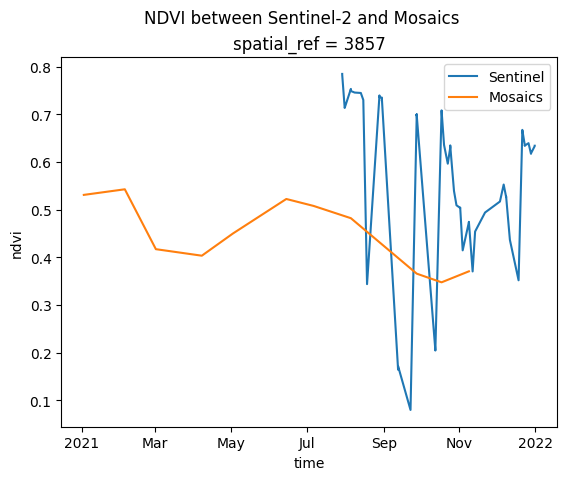

In [29]:
plt.title('NDVI between Sentinel and Mosaics')

meanval["ndvi"].plot()
meanvalV["ndvi"].plot()

plt.legend(['Sentinel', 'Mosaics'])
plt.suptitle("NDVI between Sentinel-2 and Mosaics")
    
plt.show()
